In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

pd.set_option("display.max_rows", 100)

In [2]:
oura = pd.read_csv(
    "data/oura.csv",
    index_col="day",
    parse_dates=True,
    usecols=[
        "day",
        "bedtime_end",
        "bedtime_start",
        "total_sleep_duration",
        "type",
    ],
)
# only keep sleeps
oura = oura[oura.type == "long_sleep"]
# convert to timedelta
duration_cols = [
    "total_sleep_duration",
]
oura[duration_cols] = oura[duration_cols].apply(pd.to_timedelta, args=("S"))
# convert to datetime
datetime_cols = ["bedtime_end", "bedtime_start"]
oura[datetime_cols] = oura[datetime_cols].apply(pd.to_datetime, utc=True)

In [3]:
oura["wake_secs"] = (
    oura["bedtime_end"].dt.hour * 3600
    + oura["bedtime_end"].dt.minute * 60
    + oura["bedtime_end"].dt.second
)

night_hours = oura["bedtime_start"].dt.hour + 24 * (
    oura["bedtime_start"].dt.hour < 10
).astype(int)
oura["fall_secs"] = (
    night_hours * 3600
    + oura["bedtime_start"].dt.minute * 60
    + oura["bedtime_start"].dt.second
)

In [4]:
def detect_activity(row, activity_list):
    new_row = row
    mask = [1 if activity in row["activities"] else 0 for activity in activity_list]
    new_row[3:] = mask
    return new_row


daylio = pd.read_csv(
    "data/daylio.csv",
    usecols=["full_date", "weekday", "mood", "activities"],
    index_col="full_date",
    parse_dates=True,
)
# parse activities
unique_activities = (
    daylio["activities"].str.split(r"\s*\|\s*", expand=True).stack().unique()
)
daylio["activities"] = daylio.activities.apply(lambda x: x.split(" | "))
for activity in unique_activities:
    daylio[activity] = 0
daylio = daylio.apply(lambda x: detect_activity(x, unique_activities), axis=1)
daylio.drop(columns="activities", inplace=True)
# convert moods to ordinal
mood_map = {"awful": -2, "bad": -1, "meh": 0, "good": 1, "rad": 2}
inv_mood_map = {v: k for k, v in mood_map.items()}
daylio.mood = daylio.mood.map(mood_map)

/var/folders/my/lvxg1n852nq3vf2vvjqcrzp80000gn/T/ipykernel_99600/515527678.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daylio[activity] = 0
/var/folders/my/lvxg1n852nq3vf2vvjqcrzp80000gn/T/ipykernel_99600/515527678.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daylio[activity] = 0
/var/folders/my/lvxg1n852nq3vf2vvjqcrzp80000gn/T/ipykernel_99600/515527678.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

In [5]:
# join dfs
headache_sleep = daylio.join(oura).dropna()

In [6]:
headache_sleep

,weekday,mood,Headache,Other Illness,Dairy,Fruits,Grains. beans and legumes,Red Meat,White Meat,Confections,...,Pulses,skate/surf/snow/sand board,Scuba,Camping,bedtime_end,bedtime_start,total_sleep_duration,type,wake_secs,fall_secs
full_date,,,,,,,,,,,,,,,,,,,,,
2022-08-07,Sunday,0,0,0,1,1,1,0,1,0,...,0,0,0,0,2022-08-07 07:29:22+00:00,2022-08-06 23:48:22+00:00,0 days 06:29:30,long_sleep,26962.0,85702.0
2022-08-06,Saturday,1,0,0,1,1,1,0,1,1,...,0,0,0,0,2022-08-06 08:31:04+00:00,2022-08-06 00:11:04+00:00,0 days 06:44:00,long_sleep,30664.0,87064.0
2022-08-05,Friday,1,0,0,1,1,1,1,1,1,...,0,0,0,0,2022-08-05 06:46:02+00:00,2022-08-04 23:26:02+00:00,0 days 05:59:30,long_sleep,24362.0,84362.0
2022-08-04,Thursday,1,0,0,1,1,1,1,1,0,...,0,0,0,0,2022-08-04 07:52:52+00:00,2022-08-03 23:11:52+00:00,0 days 07:37:00,long_sleep,28372.0,83512.0
2022-08-03,Wednesday,1,0,0,1,1,1,1,1,1,...,0,0,0,0,2022-08-03 06:51:59+00:00,2022-08-02 22:39:59+00:00,0 days 07:10:00,long_sleep,24719.0,81599.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31,Wednesday,1,0,0,0,0,0,0,0,1,...,0,0,0,0,2019-07-31 11:20:38+00:00,2019-07-31 04:44:38+00:00,0 days 05:54:00,long_sleep,40838.0,103478.0
2019-07-30,Tuesday,1,1,0,1,0,0,0,0,1,...,1,0,0,0,2019-07-30 12:31:24+00:00,2019-07-30 03:07:24+00:00,0 days 07:29:30,long_sleep,45084.0,97644.0
2019-07-28,Sunday,1,1,0,0,1,1,0,0,1,...,0,0,0,0,2019-07-28 07:41:53+00:00,2019-07-28 02:44:53+00:00,0 days 04:31:00,long_sleep,27713.0,96293.0


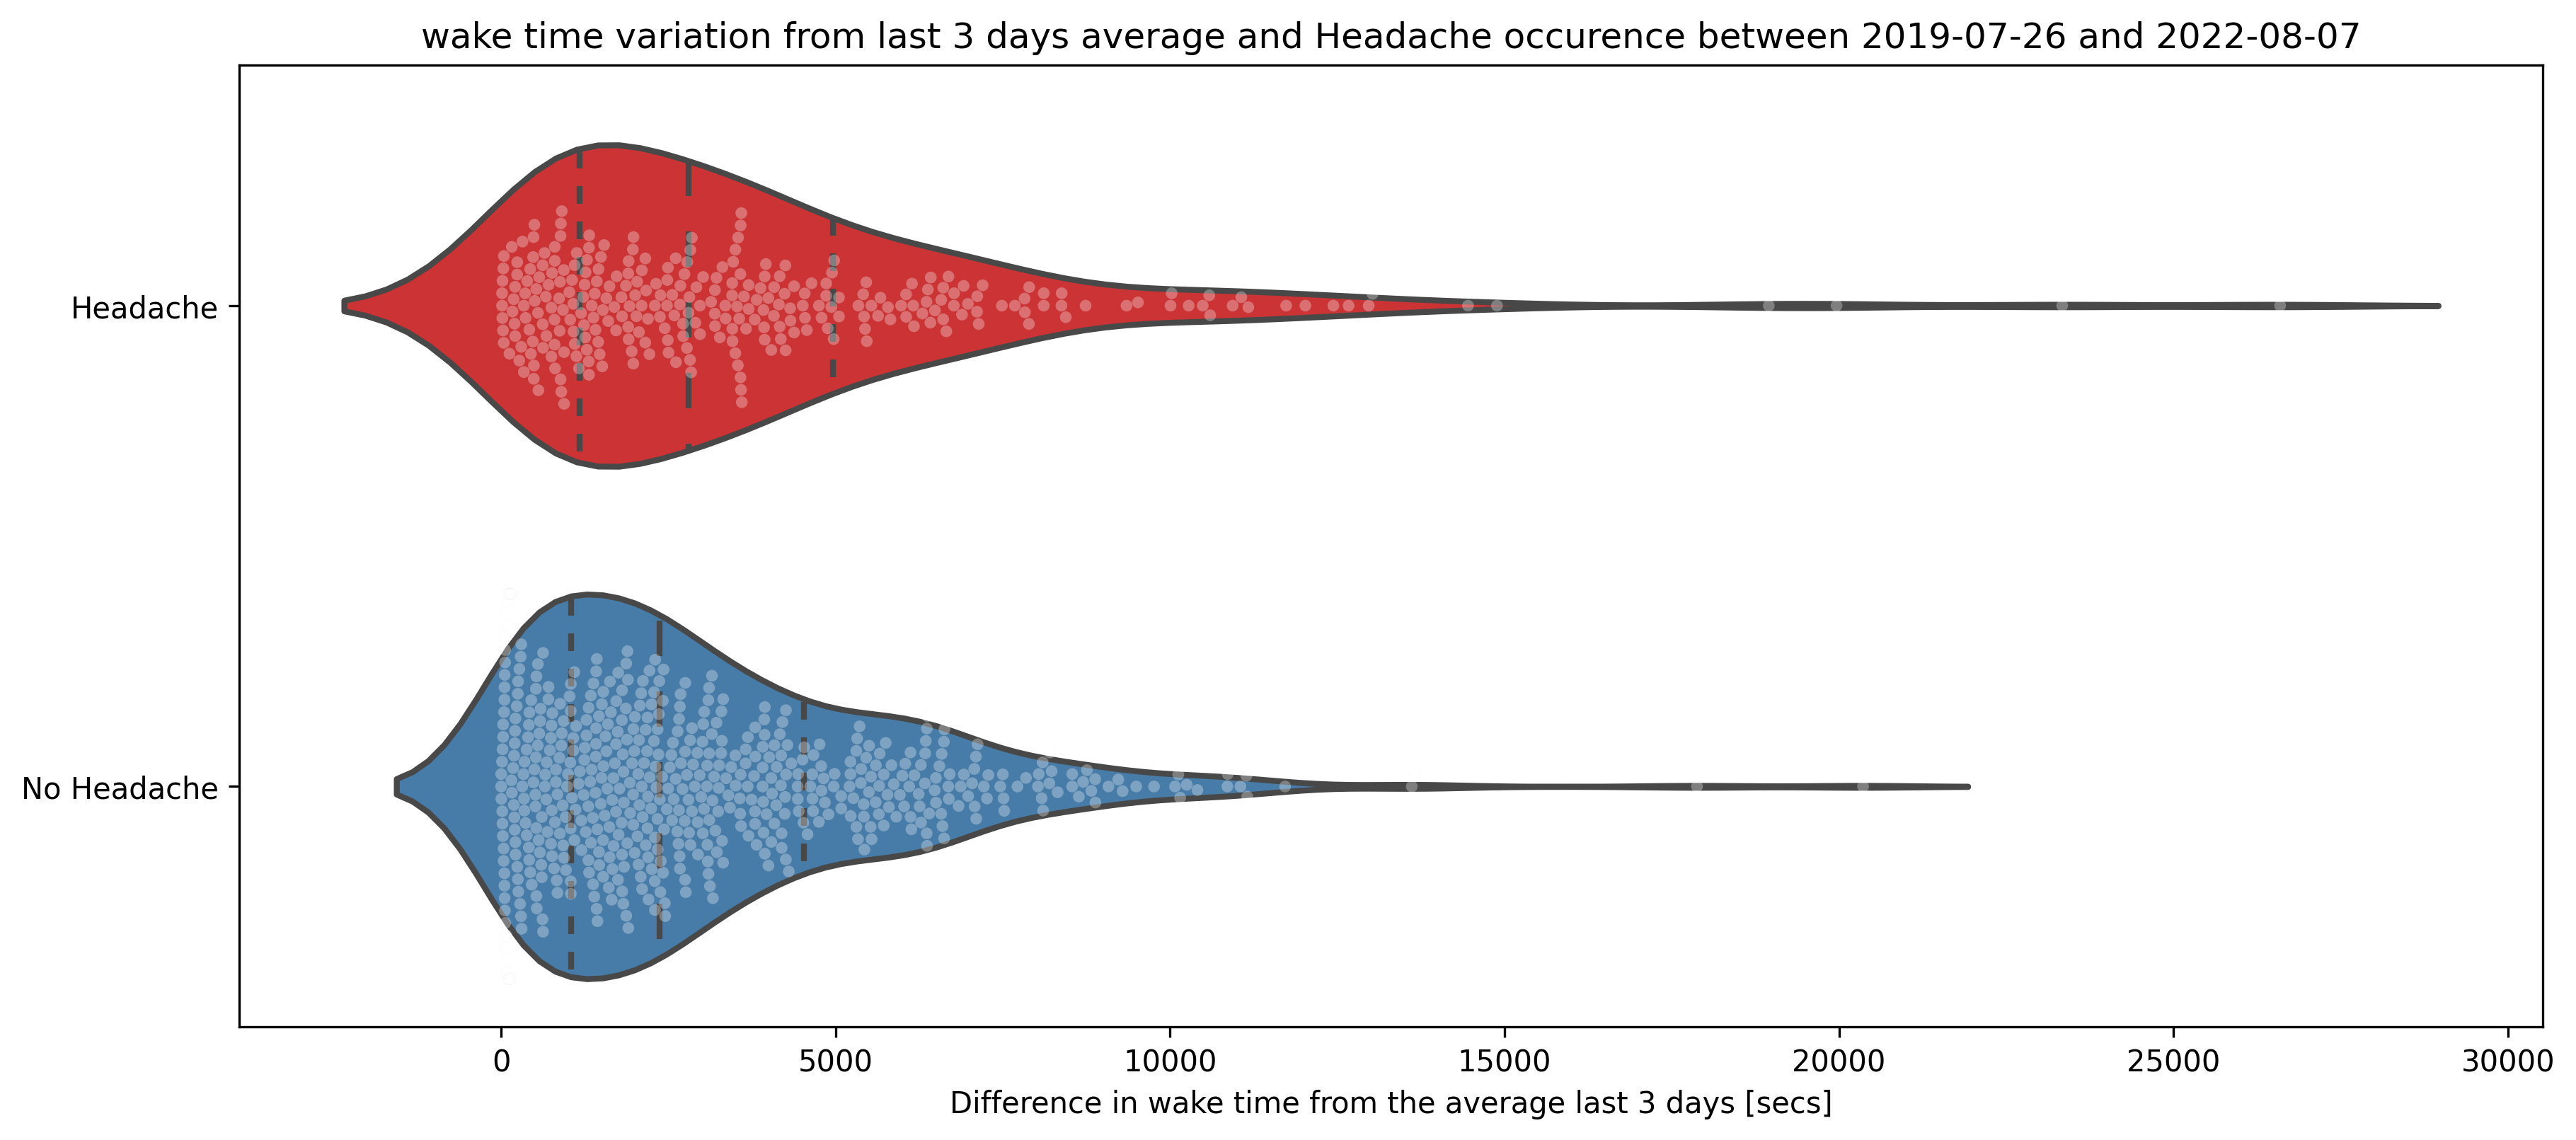

In [27]:
f, ax = plt.subplots(1, 1, figsize=(14, 6), dpi=300)

wake_or_fall = "wake"

LAST_N = 3
time_deviation = np.abs(
    headache_sleep[f"{wake_or_fall}_secs"]
    - headache_sleep[f"{wake_or_fall}_secs"].rolling(LAST_N, closed="left").mean()
)

sns.violinplot(
    y=headache_sleep.Headache,
    x=time_deviation,
    orient="h",
    scale="area",
    inner="quartile",
    linewidth=2,
    linecolor="black",
    order=[1, 0],
    palette="Set1",
)
sns.swarmplot(
    y=headache_sleep.Headache,
    x=time_deviation,
    orient="h",
    color="white",
    size=4,
    edgecolor="black",
    order=[1, 0],
    linewidth=0.01,
    alpha=0.3,
)
# ax.set_xticklabels(
#     # [time.strftime("%H:%M:%S", time.gmtime(tick)) for tick in ax.get_xticks()]
# )
ax.set_xlabel(
    f"Difference in {wake_or_fall} time from the average last {LAST_N} days [secs]"
)

ax.set_yticklabels(["Headache", "No Headache"])
ax.set_ylabel(None)

ax.set_title(
    f"{wake_or_fall} time variation from last {LAST_N} days average and Headache occurence between "
    f"{headache_sleep.index.min().date()} and {headache_sleep.index.max().date()}"
)

plt.savefig(
    f"/Users/thesofakillers/Desktop/headache_{wake_or_fall}-sleep-variation.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.show()

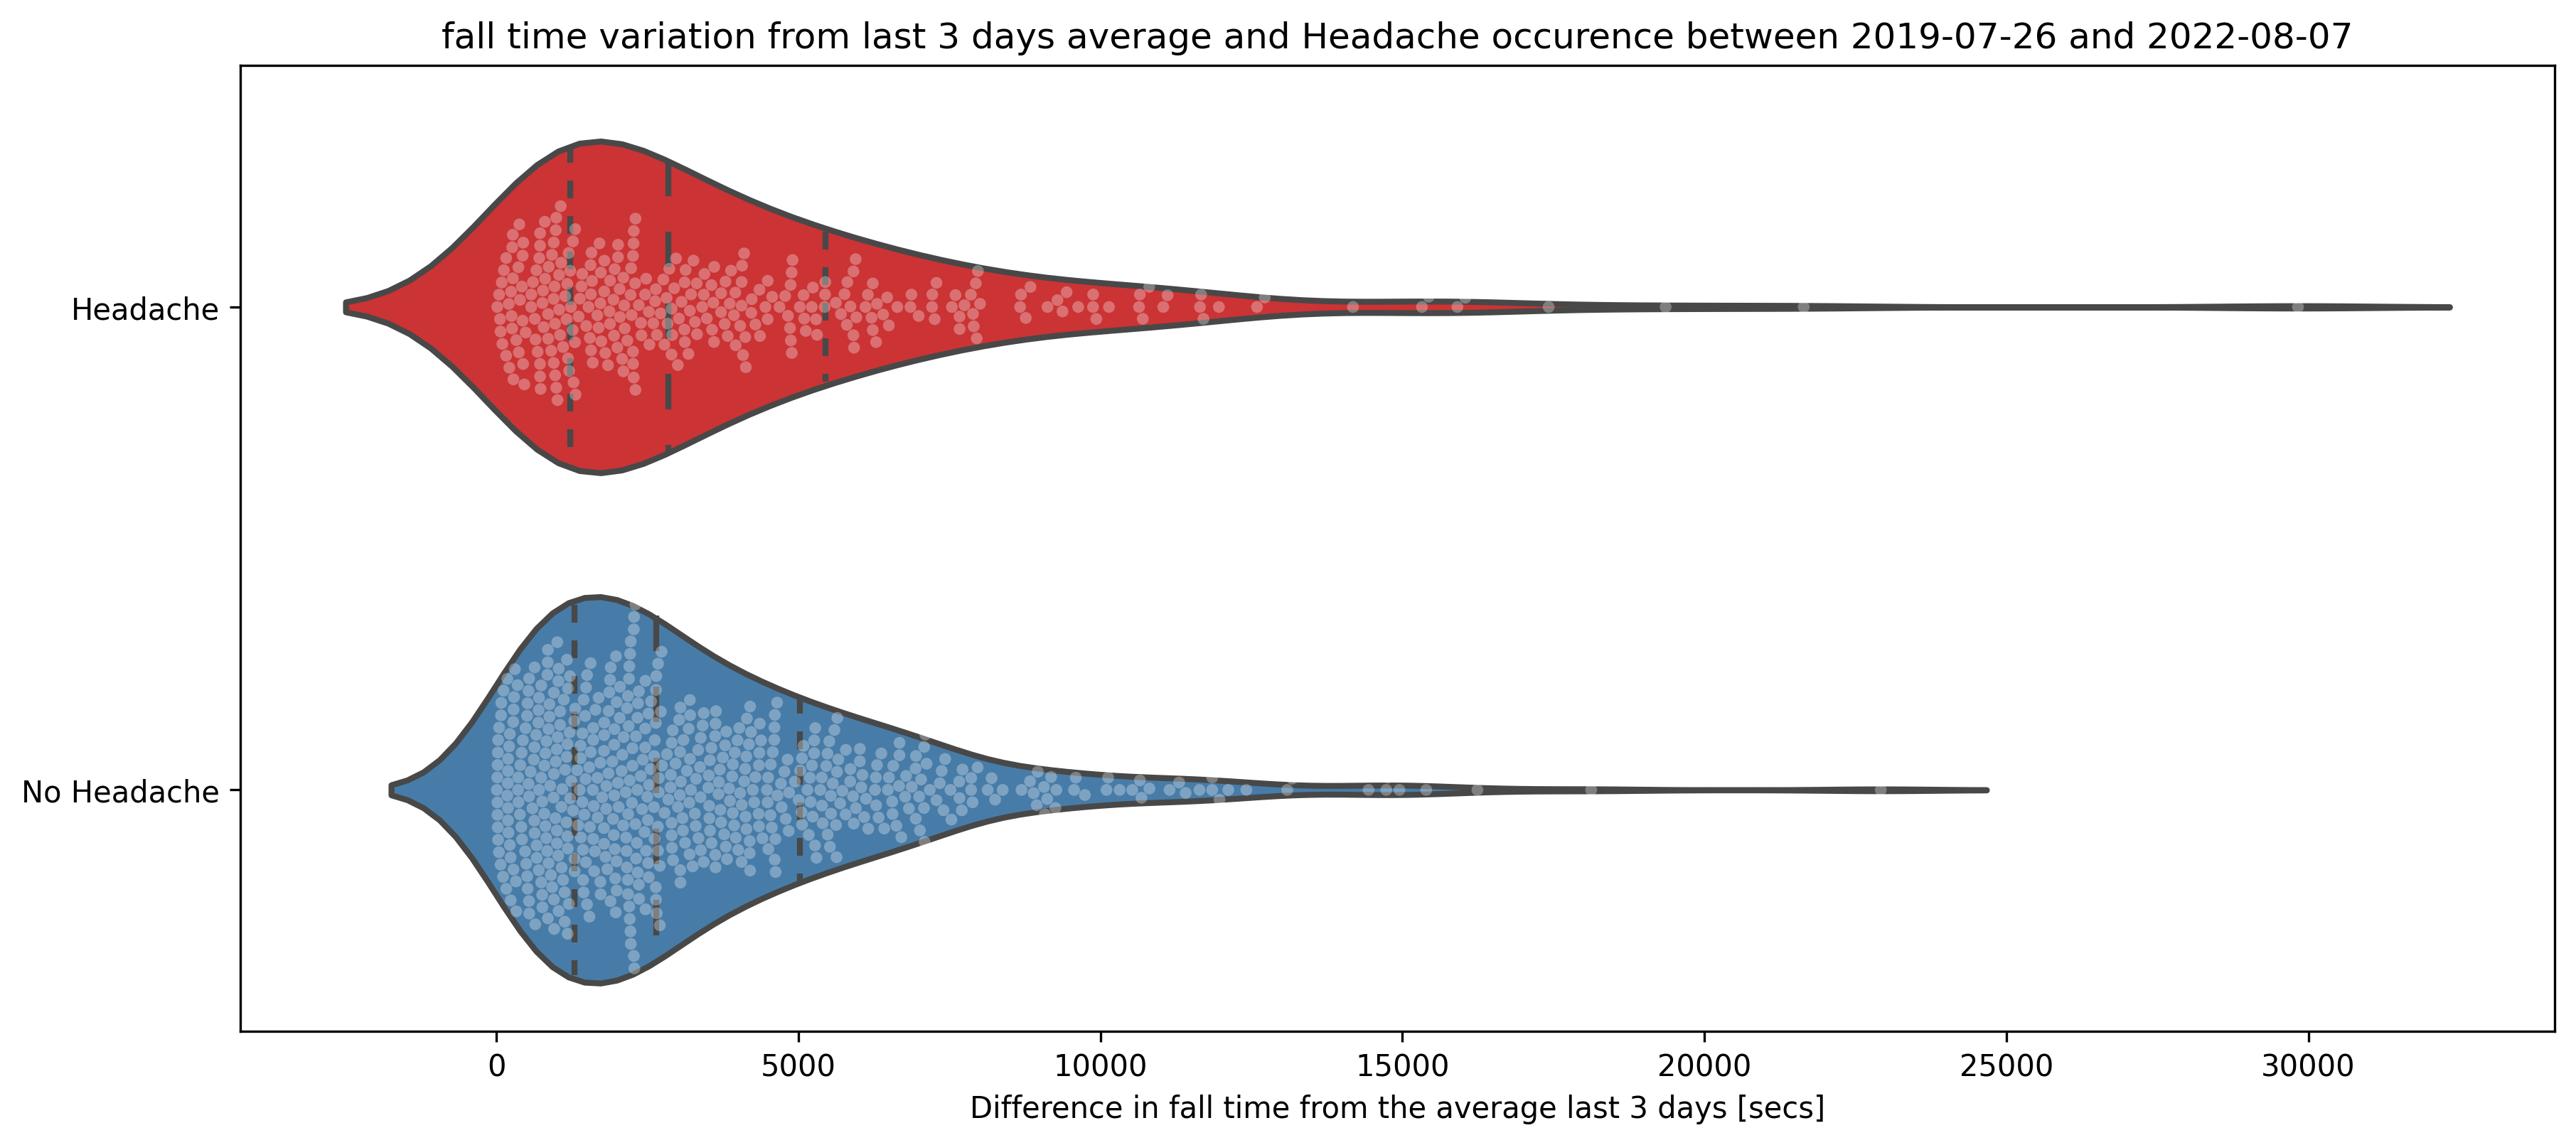

In [28]:
f, ax = plt.subplots(1, 1, figsize=(14, 6), dpi=300)

wake_or_fall = "fall"

LAST_N = 3
time_deviation = np.abs(
    headache_sleep[f"{wake_or_fall}_secs"]
    - headache_sleep[f"{wake_or_fall}_secs"].rolling(LAST_N, closed="left").mean()
)

sns.violinplot(
    y=headache_sleep.Headache,
    x=time_deviation,
    orient="h",
    scale="area",
    inner="quartile",
    linewidth=2,
    linecolor="black",
    order=[1, 0],
    palette="Set1",
)
sns.swarmplot(
    y=headache_sleep.Headache,
    x=time_deviation,
    orient="h",
    color="white",
    size=4,
    edgecolor="black",
    order=[1, 0],
    linewidth=0.01,
    alpha=0.3,
)
# ax.set_xticklabels(
#     # [time.strftime("%H:%M:%S", time.gmtime(tick)) for tick in ax.get_xticks()]
# )
ax.set_xlabel(
    f"Difference in {wake_or_fall} time from the average last {LAST_N} days [secs]"
)

ax.set_yticklabels(["Headache", "No Headache"])
ax.set_ylabel(None)

ax.set_title(
    f"{wake_or_fall} time variation from last {LAST_N} days average and Headache occurence between "
    f"{headache_sleep.index.min().date()} and {headache_sleep.index.max().date()}"
)

plt.savefig(
    f"/Users/thesofakillers/Desktop/headache_{wake_or_fall}-sleep-variation.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.show()